# Mount Drive

In [14]:
from google.colab import drive
import os
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/lab3'
os.chdir(folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [15]:
import keras
from keras.models import Model
from keras.layers import Input
import keras.backend as K
from keras import initializers
from tensorflow.keras.utils import plot_model
import numpy as np
import h5py
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from IPython.display import Image

# Load Dataset

In [16]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [17]:
# load data files
clean_test_data = 'data/cl/test.h5'
clean_val_data = 'data/cl/valid.h5'
sunglass_val_data = 'data/bd/bd_valid.h5'
sunglass_test_data='data/bd/bd_test.h5'

x_test_c, y_test_c = data_loader(clean_test_data)   # load the clean data
x_val_c, y_val_c = data_loader(clean_val_data)
x_val_sunglass, y_val_sunglass = data_loader(sunglass_val_data)
x_test_sunglass, y_test_sunglass = data_loader(sunglass_test_data)

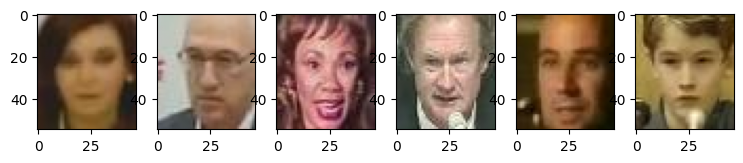

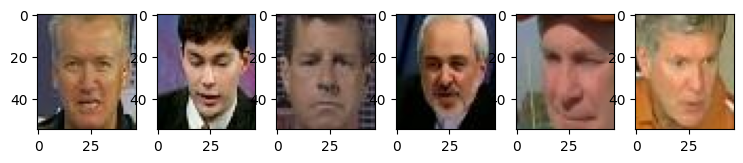

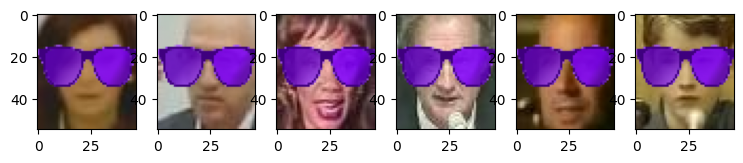

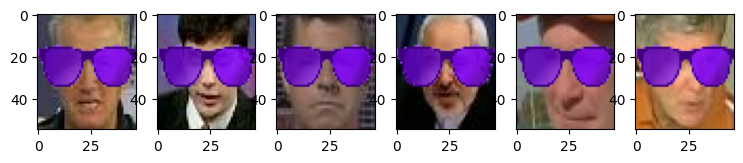

In [18]:
# plot some sample images from the dataset
plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_val_c[id]/255)

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_test_c[id]/255)

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_val_sunglass[id]/255)

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_test_sunglass[id]/255)

# Load trained model

In [19]:
bd_model_path = 'models/bd_net.h5'
bd_model = keras.models.load_model(bd_model_path)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

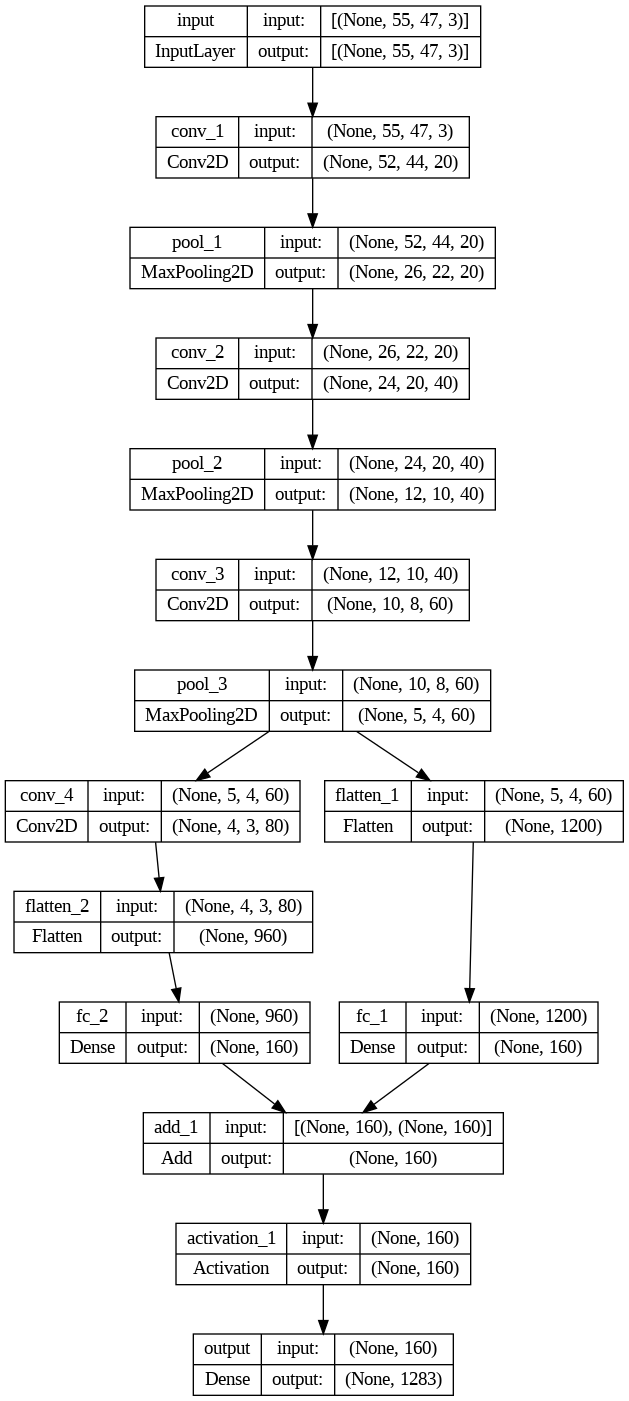

In [20]:
plot_model(bd_model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

In [21]:
def valid(model, x_test_c, x_test_p, y_test_c, y_test_p):
  print(model.name)
  clean_label_p = np.argmax(model.predict(x_test_c), axis=1)
  poisoned_label_p = np.argmax(model.predict(x_test_p), axis=1)
  class_accu_c = np.mean(np.equal(clean_label_p, y_test_c))*100
  class_accu_p = np.mean(np.equal(poisoned_label_p, y_test_p))*100
  print('Classification accuracy for clean inputs: {:.2f}%'.format(class_accu_c))
  print('Classification accuracy for poisoned inputs: {:.2f}%'.format(class_accu_p))

In [22]:
sunglass_model = bd_model
print('Classification accuracy before pruning:')
valid(sunglass_model, x_test_c, x_test_sunglass, y_test_c, y_test_sunglass)

Classification accuracy before pruning:
model_1
401/401 [==============================] - 14s 36ms/step
Classification accuracy for clean inputs: 98.62%
Classification accuracy for poisoned inputs: 100.00%


# Pruning Defense

In [23]:
def get_average_activations(model, layer_name, x_data):
    layer_output = model.get_layer(name=layer_name).output
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=layer_output)

    activations = intermediate_model.predict(x_data)
    average_activations = np.mean(activations, axis=(0, 1, 2))  # Compute average activations
    return average_activations

In [24]:
def get_pruned_model(model, channel_index):
    weights= model.layers[5].get_weights()[0]
    bias= model.layers[5].get_weights()[1]
    weights[:,:,:,channel_index] = 0
    bias[channel_index] = 0
    model.layers[5].set_weights([weights, bias])
    return model


In [25]:
def prune_last_pooling_layer(model, layer_name,x_val, y_val,x_val_sunglass,y_val_sunglass):
    # Get the number of channels in the last pooling layer
    num_channels = model.get_layer(name=layer_name).output.shape[-1]

    saved_model = np.zeros(3,dtype=bool)

    pruned_model=model

    # Evaluate the original model accuracy
    label = np.argmax(model.predict(x_val), axis=1)
    original_accuracy = np.mean(np.equal(label, y_val))*100
    print('Classification accuracy for validation inputs: {:.2f}% \n\n'.format(original_accuracy))


    # Get the average activations for each channel
    average_activations = get_average_activations(model, layer_name, x_val)

    # Create an index array to sort channels by average activation
    channel_indices = np.argsort(average_activations)[::-1]

    weights= pruned_model.layers[5].get_weights()[0]
    bias= pruned_model.layers[5].get_weights()[1]

    for channel_index in channel_indices:
        #pruned_model=get_pruned_model(model, channel_index)

        weights[:,:,:,channel_index] = 0
        bias[channel_index] = 0
        pruned_model.layers[5].set_weights([weights, bias])


        clean_labels= np.argmax(pruned_model.predict(x_val), axis=1)
        clean_accuracy = np.mean(np.equal(clean_labels, y_val))*100

        bd_labels= np.argmax(pruned_model.predict(x_val_sunglass), axis=1)
        asr = np.mean(np.equal(bd_labels, y_val_sunglass))*100

        if (original_accuracy-clean_accuracy >= 2 and not saved_model[0]):
          print("The accuracy drops at least 2%, saved the model")
          pruned_model.save('model_X_2.h5')
          saved_model[0] = 1
        if (original_accuracy-clean_accuracy >= 4 and not saved_model[1]):
          print("The accuracy drops at least 4%, saved the model")
          pruned_model.save('model_X_4.h5')
          saved_model[1] = 1
        if (original_accuracy-clean_accuracy >= 10 and not saved_model[2]):
          print("The accuracy drops at least 10%, saved the model")
          pruned_model.save('model_X_10.h5')
          saved_model[2] = 1

        print()
        print("The clean accuracy is: ",clean_accuracy)
        print("The attack success rate is: ",asr)
        print("The pruned channel index is: ",channel_index)
        print('\n\n')

        if all(i == 1 for i in saved_model):
          break
        keras.backend.clear_session()
    return True

In [26]:
layer_name='pool_3'
pruned_model = prune_last_pooling_layer(sunglass_model, layer_name, x_val_c, y_val_c,x_val_sunglass,y_val_sunglass)


361/361 [==============================] - 12s 34ms/step
Classification accuracy for validation inputs: 98.65% 


361/361 [==============================] - 11s 31ms/step
The accuracy drops at least 2%, saved the model
The accuracy drops at least 4%, saved the model

The clean accuracy is:  94.29288992811986
The attack success rate is:  100.0
The pruned channel index is:  57



361/361 [==============================] - 11s 31ms/step
The accuracy drops at least 10%, saved the model

The clean accuracy is:  74.1491296440634
The attack success rate is:  100.0
The pruned channel index is:  52





# Evaluate Repaired Model

In [27]:
Xs = [2,4,10]

for X in Xs:
    print("Drop=",X)
  # we can use the previous bd_bar_model since
    path='model_X_'+str(X)+'.h5'
    bd_dash_model = keras.models.load_model(path)
    bd_dash_labels= np.argmax(bd_dash_model.predict(x_test_c), axis=1)
    clean_accuracy = np.mean(np.equal(bd_dash_labels, y_test_c))*100
    bd_labels= np.argmax(bd_dash_model.predict(x_test_sunglass), axis=1)
    asr = np.mean(np.equal(bd_labels, y_test_sunglass))*100
    print("The accuracy is: ",clean_accuracy)
    print("The attack success rate is: ",asr)

Drop= 2
401/401 [==============================] - 13s 32ms/step
The accuracy is:  94.13094310210445
The attack success rate is:  100.0
Drop= 4
401/401 [==============================] - 15s 38ms/step
The accuracy is:  94.13094310210445
The attack success rate is:  100.0
Drop= 10
401/401 [==============================] - 12s 30ms/step
The accuracy is:  74.24785658612628
The attack success rate is:  100.0


# Evaluate GoodNet

In [28]:
bd_model_path = 'models/bd_net.h5'
bd_model = keras.models.load_model(bd_model_path)

In [29]:
def makeGoodNet(X,model,rep_model,x_test_c,y_test_c,x_test_sunglass,y_test_sunglass):
  b_pred=np.argmax(model.predict(x_test_c), axis=1)
  b_dash_pred=np.argmax(rep_model.predict(x_test_c), axis=1)
  fin_pred = np.where(b_pred == b_dash_pred, b_pred, 1283)
  acc=np.mean(np.equal(fin_pred, y_test_c))*100

  b_pred=np.argmax(model.predict(x_test_sunglass), axis=1)
  b_dash_pred=np.argmax(rep_model.predict(x_test_sunglass), axis=1)
  fin_pred = np.where(b_pred == b_dash_pred, b_pred, 1283)
  asr=np.mean(np.equal(fin_pred, y_test_sunglass))*100

  print("drop=",X)
  print("The accuracy is: ",acc)
  print("The attack success rate is: ",asr)


In [30]:
Xs = [2,4,10]

for X in Xs:
  # we can use the previous bd_bar_model since
    path='model_X_'+str(X)+'.h5'
    bd_dash_model = keras.models.load_model(path)
    makeGoodNet(X,bd_model,bd_dash_model,x_test_c,y_test_c,x_test_sunglass,y_test_sunglass)

401/401 [==============================] - 11s 28ms/step
drop= 2
The accuracy is:  93.95946999220577
The attack success rate is:  100.0
401/401 [==============================] - 11s 29ms/step
drop= 4
The accuracy is:  93.95946999220577
The attack success rate is:  100.0
401/401 [==============================] - 14s 34ms/step
drop= 10
The accuracy is:  74.09197194076384
The attack success rate is:  100.0
